# Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import json

In [2]:
%matplotlib widget
plt.rc('text', usetex = True)
plt.rcParams['figure.facecolor'] = 'w'
# plt.rcParams['figure.figsize'] = [10.0, 6.0]
# plt.rcParams['font.size'] = 16
plt.style.use('classic')

# Load data

In [3]:
path = '/Users/max/SLAC Fall 2024/LXeSims/BeZ/'

WinMat = "Be"

cols = 'x y z Px Py Pz t PDGid EventID TrackID ParentID Weight Edep VisibleEdep Ntracks'.split(' ')

with open("../analysis/z_sim_info.json", "r") as f:
    info = json.load(f)
    
n_events = info["n_events"]

df_LXe = pd.read_csv(path+'LXe.txt', skiprows=1, header=0, delim_whitespace=True, names=cols)

df_EntranceWin = pd.read_csv(path+'WinIn.txt', skiprows=1, header=0, delim_whitespace=True, names=cols)
df_ExitWin = pd.read_csv(path+'WinOut.txt', skiprows=1, header=0, delim_whitespace=True, names=cols)

# Electron charge in C
e_charge = 1.602176634e-19

# Material densities in g/cm^3 (https://www.fe.infn.it/u/paterno/Geant4_tutorial/slides_further/Geometry/G4_Nist_Materials.pdf)

WinVol = np.pi * info["WinProperties"]["r_window"]**2 * info["WinProperties"]["Win_thickness"] # cm^3
WinMass = WinVol * info["rho"][WinMat] # g

# Slice info

In [4]:
eps = 2 # width of slice of LXe to plot (mm)
xmask = abs(df_LXe['x']) <= eps/2
ymask = abs(df_LXe['y']) <= eps/2
z_pos = (info["LXeDim"][2]*10-eps/2) # z-coordinate of (center of) slice to plot (mm)
zmask = ((df_LXe['z'] >= z_pos - eps/2) & (df_LXe['z'] <= z_pos + eps/2))

slice_masks = {'x': xmask, 'y': ymask, 'z': zmask}

xz = df_LXe[slice_masks['y']]
xy = df_LXe[slice_masks['z']]

# Define PEDD Calculation for LXe

In [58]:
def calculate_PEDD(projection: str, bins: list) -> pd.DataFrame:
    '''
    Parameters
    ----------
        projectrion : str
            Desired plane to project onto for plotting. Options are 'x', 'y', and 'z'.
        bins : list
            List of integers describing the number of horizontal and vertical bins, respectively.

    Returns
    -------
        PEDD : pd.DataFrame
            Pandas DataFrame containing PEDD values corresponding to [nx,ny] bins for hist2d.

    '''
    d = {'z': 0, 'x': 1, 'y': 2} # Arranged so that the 'x' and 'y' projections puts z on the x-axis of the histogram
    axes = [val for key,val in d.items() if key != projection]
    
    # Calculate the mass corresponding to a bin of the 2D histogram
    volume = eps/10 * info["LXeDim"][axes[0]]/bins[0] * info["LXeDim"][axes[1]]/bins[1] # cm^3
    LXe_bin_mass = volume * info["rho"]["LXe"] # g
    
    # Electron charge in C
    e_charge = 1.602176634e-19

    # Extract Edep, convert MeV to J, divide by mass of bin
    PEDD = df_LXe[slice_masks[projection]]['Edep'] * 1e6 * e_charge / LXe_bin_mass # J/g

    return PEDD

# Print energy deposition information

In [14]:
print(f'######### Mean Edep/incident e- #########\n\nLXe:\t{df_LXe["Edep"].sum()/n_events:.2f} MeV/e-')
print(f'Entrance Window: {df_EntranceWin["Edep"].sum()/n_events:.2f} MeV/e-\nExit Window:\t{df_ExitWin["Edep"].sum()/n_events:.2f} MeV/e-\n')

######### Mean Edep/incident e- #########

LXe:	488.71 MeV/e-
Entrance Window: 0.57 MeV/e-
Exit Window:	7.97 MeV/e-



# Check z distribution

For histograms involving z, the recommended number of bins should not exceed 1/10 the number of z slices of LXe.

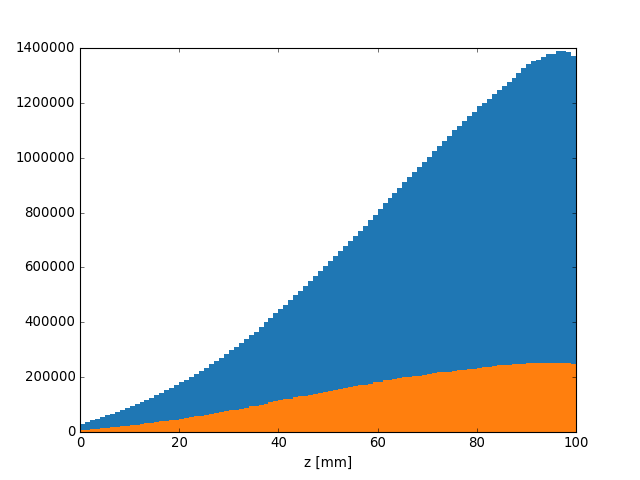

In [7]:
bn = 100

plt.close()
plt.figure()
plt.hist(df_LXe['z'], bins=bn, linewidth=0, facecolor = 'tab:blue')
plt.hist(xz['z'], bins=bn, linewidth=0, facecolor = 'tab:orange')
plt.xlabel('z [mm]')
plt.show()

# Window Plots

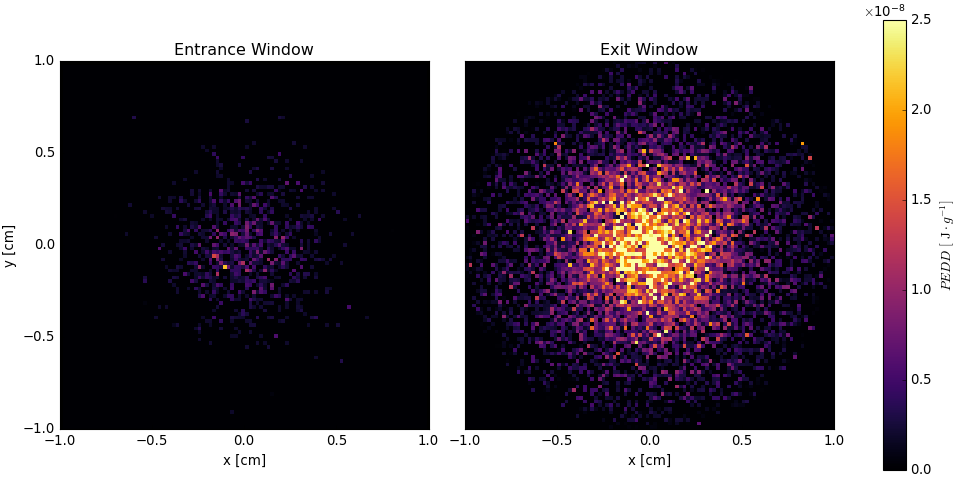

In [21]:
WinKey = 'pedd' # edep or pedd


names = ['Entrance Window', 'Exit Window']
labels = {'edep': r'$E_{dep}\ \left[\mathrm{MeV}\right]$', 'pedd': r'$PEDD\ \left[\ \mathrm{J}\cdot g^{-1}\right]$'}
WinEdep = [
    df_EntranceWin,
    df_ExitWin
    ]

vmin = 0
vmax = 2.5e-8
n = 100 # n by n grid

bin_vol = (2*info["WinProperties"]["r_window"]/n)**2 * info["WinProperties"]["Win_thickness"] # cm^3
bin_mass = bin_vol * info["rho"][WinMat] # g
mass = {'edep': 1, 'pedd': bin_mass / (1e6 * e_charge)}

plt.close()
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,6), constrained_layout=True)
for i in range(2):
    h = ax[i].hist2d(
        x=WinEdep[i]['x']/10,
        y=WinEdep[i]['y']/10,
        weights=WinEdep[i]['Edep']/mass[WinKey],
        bins=n,
        cmap='inferno',
        vmin=vmin,
        vmax=vmax, # need to set these, otherwise the left subplot does not obey the colorbar
    )
    # ax[i].autoscale_view()
    ax[i].set_xlabel('x [cm]')
    # ax[i].set_xticks(np.arange(-1,1.25,0.25))
    # ax[i].set_yticks(np.arange(-1,1.25,0.25))
    ax[i].set_xlim(-1,1)
    ax[i].set_title(names[i])
    ax[i].set_aspect('equal')
    ax[i].set_facecolor('black')
ax[0].set_ylabel('y [cm]')
ax[0].set_ylim(-1,1)
cb = fig.colorbar(h[3], ax=ax[1], label=labels[WinKey])
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.show()

# LXe $E_{\mathrm{dep}}$ Plots

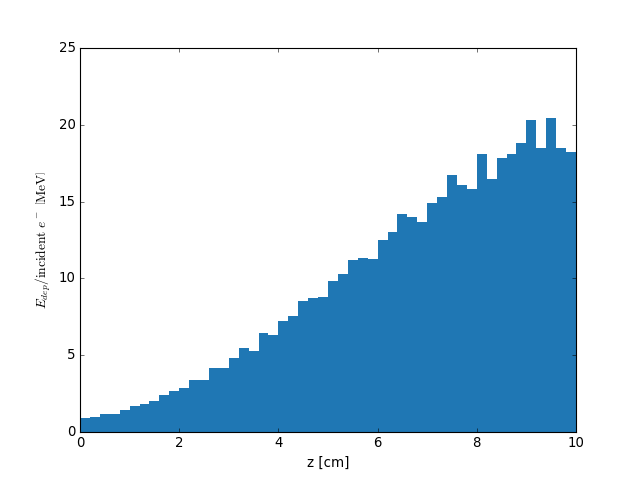

In [9]:
plt.close()
plt.figure()
plt.hist(x=df_LXe['z']/10, weights=df_LXe['Edep']/n_events, bins=50, facecolor = 'tab:blue', linewidth=0)
plt.xlabel('z [cm]')
plt.ylabel(r'$E_{dep}/\mathrm{incident}\ e^-\ \left[\mathrm{MeV}\right]$')
plt.show()

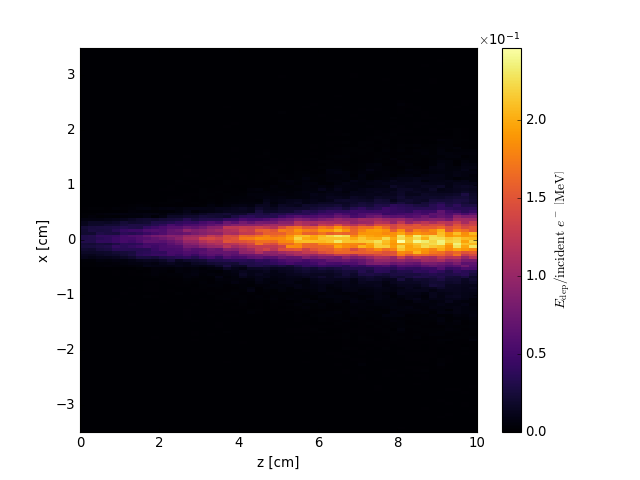

In [10]:
plt.close()
plt.figure()
plt.hist2d(x=xz['z']/10, y=xz['x']/10, weights=xz['Edep']/n_events, bins=[50,140], cmap='inferno')
plt.xlabel('z [cm]')
plt.ylabel('x [cm]')
cb = plt.colorbar(label=r'$E_{\mathrm{dep}}/\mathrm{incident}\ e^-\ \left[\mathrm{MeV}\right]$')
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
# plt.gca().set_aspect(aspect=info["LXeDim"][0]/info["LXeDim"][1])
plt.show()

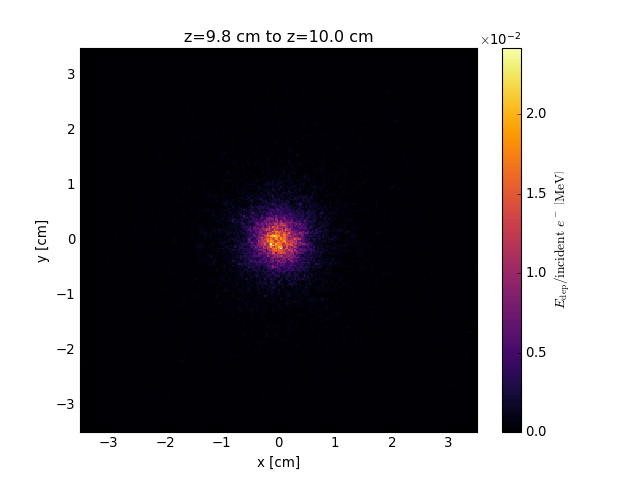

In [11]:
plt.close()
plt.figure()
plt.hist2d(x=xy['x']/10, y=xy['y']/10, weights=xy['Edep']/n_events, bins=250, cmap='inferno')
# plt.hist2d(x=xy['x']/10, y=xy['y']/10, weights=xy['Edep']/n_events, bins=1000, cmap='inferno', vmax=5e-4)
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title(f'z={(z_pos-eps/2)/10} cm to z={(z_pos+eps/2)/10} cm')
cb = plt.colorbar(label=r'$E_{\mathrm{dep}}/\mathrm{incident}\ e^-\ \left[\mathrm{MeV}\right]$')
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.show()

# LXe PEDD Plots

In [71]:
xz_bins=[50,35]
xz_PEDD = calculate_PEDD(projection='y', bins=xz_bins)

n = 100
xy_bins=[n, n]
xy_PEDD = calculate_PEDD(projection='z', bins=xy_bins)

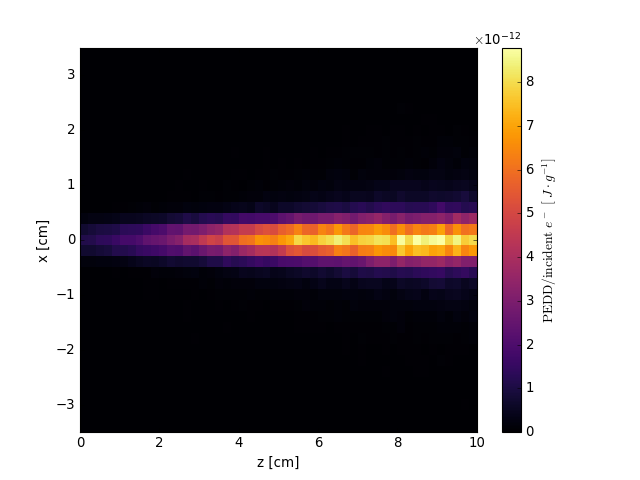

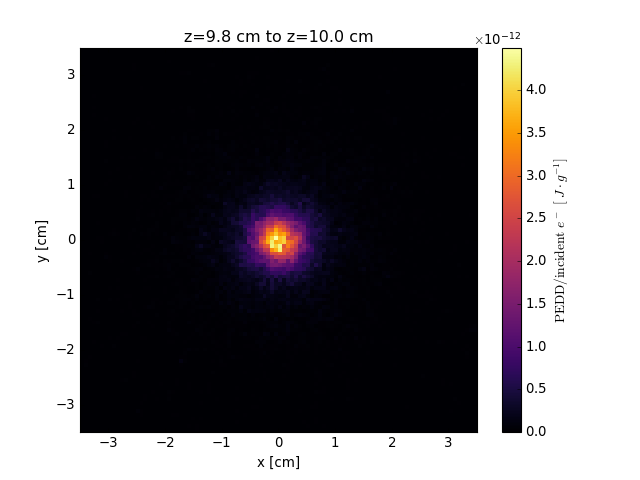

In [53]:
plt.close()
plt.figure()
plt.hist2d(x=xz['z']/10, y=xz['x']/10, weights=xz_PEDD/n_events, bins=xz_bins, cmap='inferno')
plt.xlabel('z [cm]')
plt.ylabel('x [cm]')
cb = plt.colorbar(label=r'$\mathrm{PEDD}/\mathrm{incident}\ e^-\ \left[\ J\cdot g^{-1}\right]$')
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
# plt.gca().set_aspect(aspect=info["LXeDim"][0]/info["LXeDim"][1])
plt.show()

plt.close()
plt.figure()
plt.hist2d(x=xy['x']/10, y=xy['y']/10, weights=xy_PEDD/n_events, bins=n, cmap='inferno')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title(f'z={(z_pos-eps/2)/10} cm to z={(z_pos+eps/2)/10} cm')
cb = plt.colorbar(label=r'$\mathrm{PEDD}/\mathrm{incident}\ e^-\ \left[\ J\cdot g^{-1}\right]$')
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.show()

# Print PEDD Information

Calculate additional info for windows

In [73]:
ndivs = 6

bin_vol = (2*info["WinProperties"]["r_window"]/ndivs)**2 * info["WinProperties"]["Win_thickness"] # cm^3
bin_mass = bin_vol * info["rho"][WinMat] # g
mass = {'edep': 1, 'pedd': bin_mass / (1e6 * e_charge)}

EntrancePEDD = df_EntranceWin['Edep'].sum() * 1e6 * e_charge / bin_mass # J/g
ExitPEDD = df_ExitWin['Edep'].sum() * 1e6 * e_charge / bin_mass # J/g

print(bin_vol) # volume of tub from other version is 0.0054 cm^3

0.005555555555555556


In [72]:
print(f'\n######### Total PEDD/{n_events:.0f} e- #########\n\nLXe:\t{xz_PEDD.sum():.2e} J/g')
print(f'Entrance Window: {EntrancePEDD:.2e} J/g\nExit Window:\t{ExitPEDD:.2e} J/g\n')

# print(f'\n######### PEDD/incident e- #########\n\nLXe:\t{xz_PEDD.sum()/n_events:.2e} J/g')
# print(f'Entrance Window: {EntrancePEDD/n_events:.2e} J/g\nExit Window:\t{ExitPEDD/n_events:.2e} J/g\n')


######### Total PEDD/1000 e- #########

LXe:	1.06e-06 J/g
Entrance Window: 8.85e-09 J/g
Exit Window:	1.24e-07 J/g

